In [1]:
import sys

# cd to ../src
sys.path.append("../")
from src.trainer import ConcatDataset
from src.dataset.dataset import CollieDataset, DataCollatorForCoLLIE
from torch.utils.data import DataLoader
import os
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
import logging

logging.basicConfig(level=logging.INFO)

[2023-07-03 15:08:58,619] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /ikerlariak/osainz006/venvs/collie/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda-11.7/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.0
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /ikerlariak/osainz006/venvs/collie/lib/python3.9/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/ikerlariak/osainz006/venvs/collie/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/boost/lib'), PosixPath('/usr/lib/boost-1.46.1')}
  warn(msg)


In [2]:
# Set for local execution, leave empty for running it on the server
# local_path = "/run/user/1000/gvfs/sftp:host=tximista.ixa.eus,user=igarcia945/"
local_path = ""

In [3]:
dataset_dir = f"{local_path}/ikerlariak/osainz006/CoLLIE/data/processed_incr"
tasks = [
    "ace05.ner",
    "ace05.re",
    "ace05.rc",
    "ace05.ee",
    "ace05.eae",
    "conll03.ner",
    "rams.eae",
    # "tacred.re",
    # "tacred.sf",
    # "wikievents.eae",
    # "wikievents.ee",
    # "wikievents.ner",
]
print(dataset_dir)
print(tasks)

/ikerlariak/osainz006/CoLLIE/data/processed_incr
['ace05.ner', 'ace05.re', 'ace05.rc', 'ace05.ee', 'ace05.eae', 'conll03.ner', 'rams.eae']


In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    f"{local_path}/gaueko1/hizkuntza-ereduak/LLaMA/lm/huggingface/7B/",
    add_eos_token=True,
)
tokenizer.padding_side = "left"
if tokenizer.pad_token_id is None:
    if "<|padding|>" in tokenizer.get_vocab():
        # StabilityLM specific fix
        tokenizer.add_special_tokens({"pad_token": "<|padding|>"})
    elif tokenizer.unk_token is not None:
        print("Model does not have a pad token, we will use the unk token as pad token.")
        tokenizer.pad_token_id = tokenizer.unk_token_id
    else:
        print("Model does not have a pad token. We will use the eos token as pad token.")
        tokenizer.pad_token_id = tokenizer.eos_token_id

Model does not have a pad token, we will use the unk token as pad token.


In [5]:
training_datasets = []
for train_task in tqdm(tasks):
    train_path = os.path.join(dataset_dir, f"{train_task}.train.jsonl")
    train_dataset = CollieDataset(
        tokenizer=tokenizer,
        dataset_path=train_path,
        max_length=2048,
        is_encoder_decoder=True,
        inference=False,
        prompt_loss_weight=0.0,
    )
    training_datasets.append(train_dataset)

train_dataset = ConcatDataset(training_datasets)

  0%|          | 0/7 [00:00<?, ?it/s]

INFO:root:Found 3 pre-computed epoch datasets.
INFO:root:Loaded [19217, 19217, 19217] examples from /ikerlariak/osainz006/CoLLIE/data/processed_incr/ace05.ner.train.jsonl
INFO:root:Found 3 pre-computed epoch datasets.
INFO:root:Loaded [19217, 19217, 19217] examples from /ikerlariak/osainz006/CoLLIE/data/processed_incr/ace05.re.train.jsonl
INFO:root:Found 3 pre-computed epoch datasets.
INFO:root:Loaded [5691, 5691, 5691] examples from /ikerlariak/osainz006/CoLLIE/data/processed_incr/ace05.rc.train.jsonl
INFO:root:Found 3 pre-computed epoch datasets.
INFO:root:Loaded [19217, 19217, 19217] examples from /ikerlariak/osainz006/CoLLIE/data/processed_incr/ace05.ee.train.jsonl
INFO:root:Found 3 pre-computed epoch datasets.
INFO:root:Loaded [3843, 3843, 3843] examples from /ikerlariak/osainz006/CoLLIE/data/processed_incr/ace05.eae.train.jsonl
INFO:root:Found 3 pre-computed epoch datasets.
INFO:root:Loaded [14041, 14041, 14041] examples from /ikerlariak/osainz006/CoLLIE/data/processed_incr/conll

In [6]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    collate_fn=DataCollatorForCoLLIE(
        tokenizer,
        pad_to_multiple_of=8,
        return_tensors="pt",
        padding=True,
        label_pad_token_id=-100,
    ),
    shuffle=True,
)

In [ ]:
# Get the len of each batch
batch_lens = []
for batch in tqdm(train_dataloader):
    batch_lens.append(batch["input_ids"].shape[1])

In [14]:
print(f"Total batches: {len(batch_lens)}")

avg_batch_len = sum(batch_lens) / len(batch_lens)
print(f"Average batch length: {avg_batch_len}")

max_batch_len = max(batch_lens)
print(f"Max batch length: {max_batch_len}")

min_batch_len = min(batch_lens)
print(f"Min batch length: {min_batch_len}")

top_10 = sorted(batch_lens, reverse=True)[:10]
print(f"Top 10 batch lengths: {top_10}")

top_1_percent = sorted(batch_lens, reverse=True)[: int(len(batch_lens) * 0.01)]
print(f"Top 1% batch lengths: {top_1_percent}")

top_01_percent = sorted(batch_lens, reverse=True)[: int(len(batch_lens) * 0.001)]
print(f"Top 0.1% batch lengths: {top_01_percent}")

idxs_of_top_10 = [batch_lens.index(x) for x in top_10]
print(f"Indexes of top 10 batch lengths: {idxs_of_top_10}")

Total batches: 2768
Average batch length: 812.1589595375723
Max batch length: 1136
Min batch length: 648
Top 10 batch lengths: [1136, 1128, 1120, 1120, 1096, 1096, 1088, 1088, 1088, 1088]
Top 1% batch lengths: [1136, 1128, 1120, 1120, 1096, 1096, 1088, 1088, 1088, 1088, 1088, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1080, 1072, 1072, 1072, 1072, 1072, 1072, 1072]
Top 0.1% batch lengths: [1136, 1128]
Indexes of top 10 batch lengths: [710, 695, 1027, 1027, 1249, 1249, 546, 546, 546, 546]


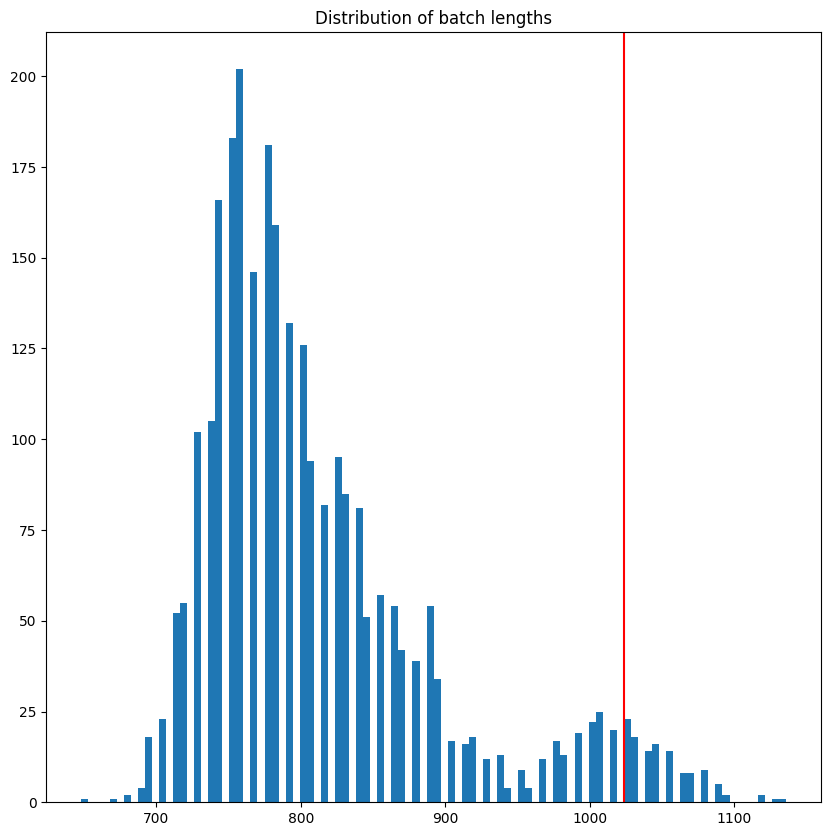

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.hist(batch_lens, bins=100)
plt.title("Distribution of batch lengths")
plt.axvline(1024, color="red")

NameError: name 'ax' is not defined

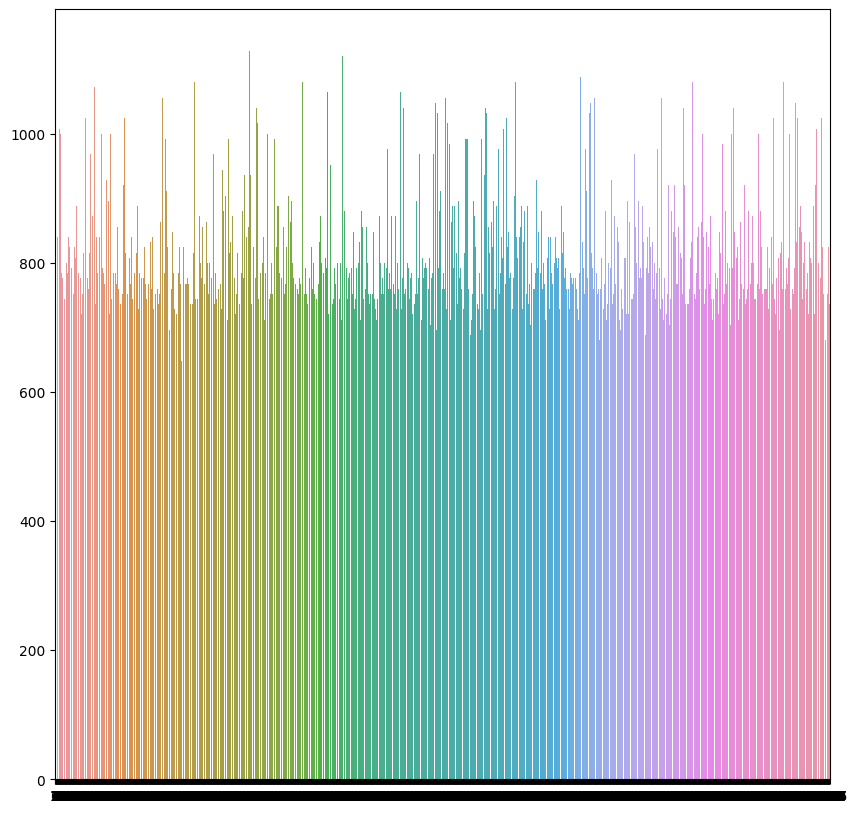

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.figure(figsize=(10, 10))
sns.barplot(x=np.arange(len(batch_lens)), y=batch_lens)
ax.bar_label(ax.containers[0])
plt.axis("off")
plt.show()